# ISA on scclevr with MyBigResNet as encoder

Using the common Evalution Framework, I like to compare it to the benchmark ISA!

This is a bigger ResNet then the "MyResNet" but also does not use bottleneck tecinque.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import InvariantSlotAttention

from matplotlib.patches import Circle
import json

# Set numpy seed for test set sampling 
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
cID_prev = 'isa-scclevr-EncStudy-myBigResNet'
with open(f'./../../code/configs/encoder-studies/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [4]:
m = InvariantSlotAttention(**hps)

Using MyBigResNet to encode data.


In [5]:
f = open(f'./../../code/models/{cID_prev}/loss.json')
# returns JSON object as a dictionary
losses = json.load(f)

loss  tot  min:  0.026217175647616386  at  14758
loss  bce  min:  0.008798770606517792  at  14715
loss  mse  min:  0.005256034433841705  at  14996


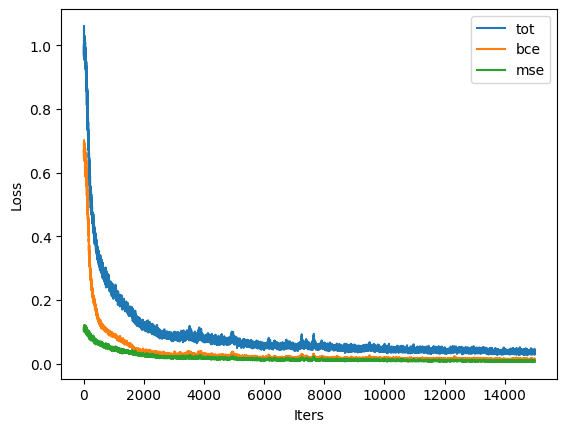

In [6]:
for k,v in losses.items():
    plt.plot(v,label=k)
    print("loss ", k, " min: ", np.min(v), " at ", np.argmin(v))
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
lastIter = 15000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 15000


<All keys matched successfully>

### Evaluate the model

Use the common evaluation framework

In [8]:
import scclevr
os.sys.path.append('./../../../evaluation')
from dataset import TestDataset
import model_performance as ev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
ds = TestDataset()
X = torch.FloatTensor(ds.event_images).to(device)

In [10]:
with torch.no_grad():
    queries, att, Y_pred = m(X) 

In [11]:
mp = ev.Model_performance(ds, att)
mp.hungarian_matching()

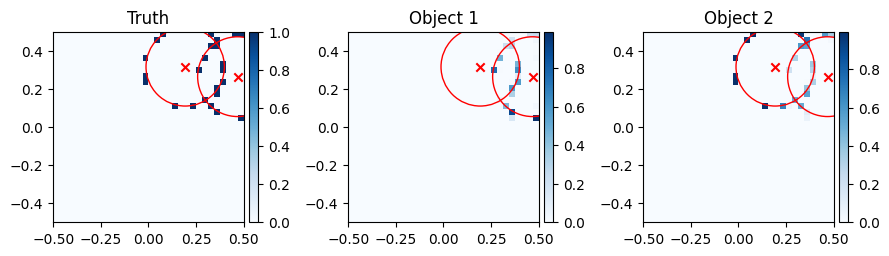

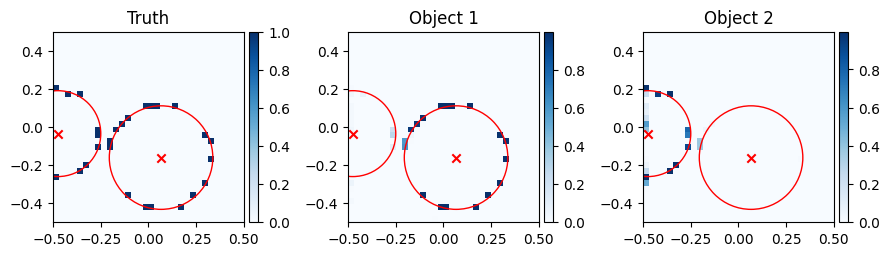

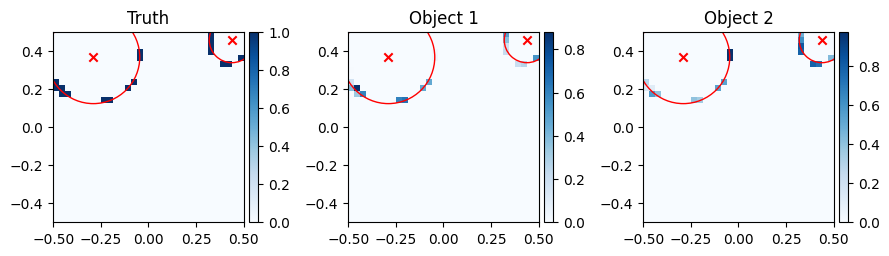

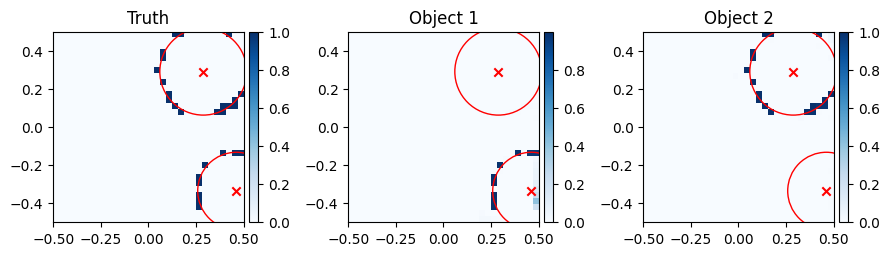

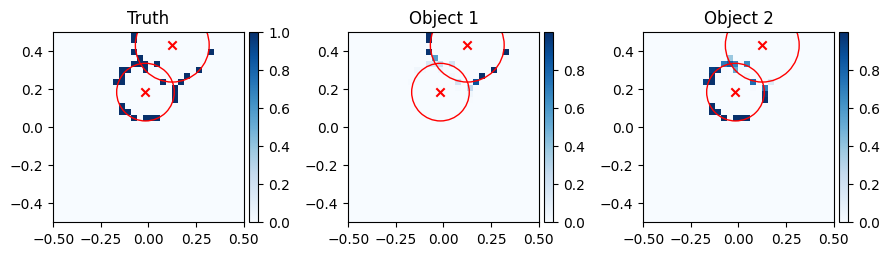

In [12]:
for i in range(5):
    mp.plot_instance_i(i)

In [13]:
loss = mp.KL_loss()
np.log10(loss)

tensor(-3.6145)

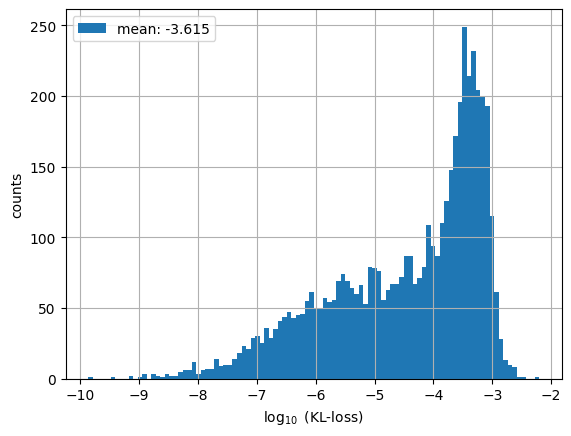

In [14]:
n, bins = mp.loss_hist()

In [17]:
#with open('MyBigResNet.npy', 'wb') as f:
#    np.save(f, n)
#    np.save(f, bins)

Mhhhh .... Best network until now and still not as good as Florians...why?



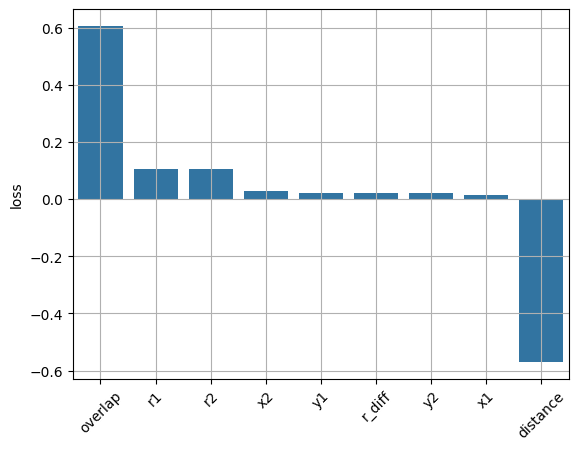

overlap     0.606010
r1          0.105087
r2          0.103846
x2          0.027725
y1          0.022930
r_diff      0.022709
y2          0.020928
x1          0.014854
distance   -0.569875
Name: loss, dtype: float64

In [15]:
mp.Pearson_correlation_coefficients()

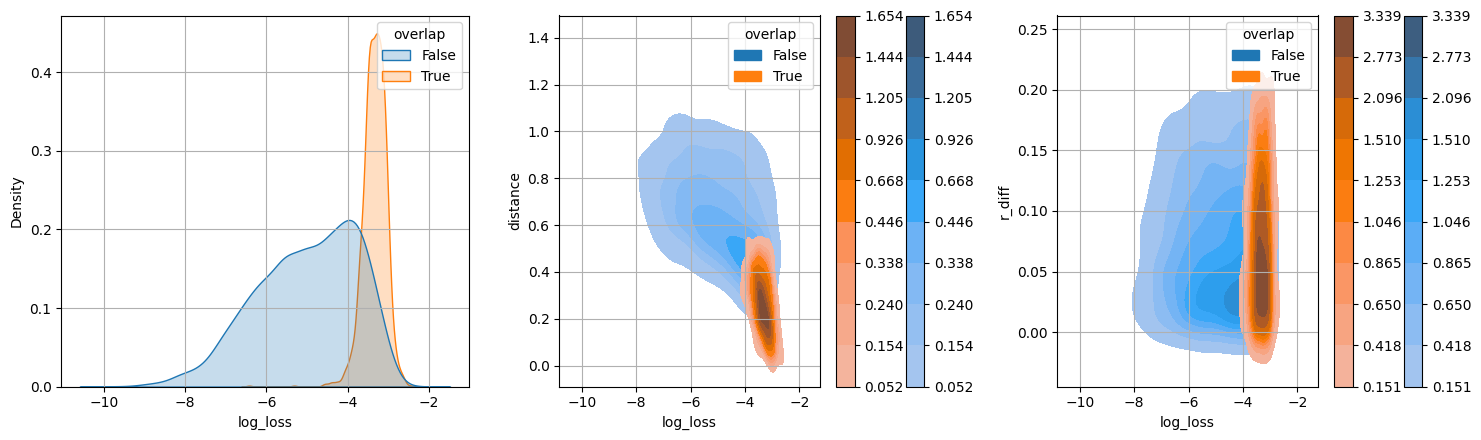

In [16]:
mp.KDE_hist()

### Plot loss as a function to of the distance to the border!

In [17]:
df = mp._make_dataframe()

In [18]:
df

,loss,x1,x2,y1,y2,r1,r2,r_diff,distance,overlap,log_loss
0,0.000626,0.192743,0.467288,0.315817,0.264227,0.205751,0.209313,0.003562,0.279350,True,-3.203559
1,0.000069,0.065993,-0.475816,-0.160486,-0.034719,0.271690,0.225408,0.046282,0.556214,False,-4.158365
2,0.000925,-0.289524,0.437925,0.366505,0.456615,0.243732,0.118961,0.124771,0.733009,False,-3.034045
3,0.000006,0.461140,0.287637,-0.335305,0.290680,0.202778,0.228139,0.025361,0.649585,False,-5.202619
4,0.000312,0.124826,-0.015858,0.429753,0.183091,0.193727,0.151172,0.042555,0.283962,True,-3.505290
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.000424,-0.317132,-0.345074,0.206015,0.350084,0.268334,0.098770,0.169564,0.146754,True,-3.372746
4996,0.000006,-0.188684,0.159355,-0.217556,0.298772,0.244552,0.241396,0.003156,0.622676,False,-5.248517
4997,0.000760,-0.489582,0.084754,-0.399922,-0.423801,0.290329,0.284789,0.005540,0.574832,True,-3.119325
4998,0.000010,-0.390122,-0.129246,-0.084974,0.455984,0.223434,0.171159,0.052275,0.600577,False,-4.999130


In [22]:
df.shape

(5000, 11)

In [24]:
overlap_edge_obj1 = [True if (abs(df["x1"][i])+df["r1"][i]>0.5) or (abs(df["y1"][i])+df["r1"][i]>0.5) else False for i in range(df.shape[0])]
overlap_edge_obj2 = [True if (abs(df["x2"][i])+df["r2"][i]>0.5) or (abs(df["y2"][i])+df["r2"][i]>0.5) else False for i in range(df.shape[0])]

In [25]:
overlap_edge_any = [overlap_edge_obj1 or overlap_edge_obj2]

In [35]:
len(overlap_edge_any[0])

5000

In [26]:
overlap_edge_both = [overlap_edge_obj1 and overlap_edge_obj2]

In [38]:
overlap_edge = [2 if (overlap_edge_obj1[i] and overlap_edge_obj2[i]) else (1 if overlap_edge_obj1[i] or overlap_edge_obj2[i] else 0) for i in range(df.shape[0])]

In [39]:
df["overlap_edge"] = overlap_edge

In [41]:
import seaborn as sns

In [43]:
df["overlap_edge"].value_counts(normalize=True)

overlap_edge
1    0.4820
2    0.3644
0    0.1536
Name: proportion, dtype: float64

<Axes: xlabel='log_loss', ylabel='Density'>

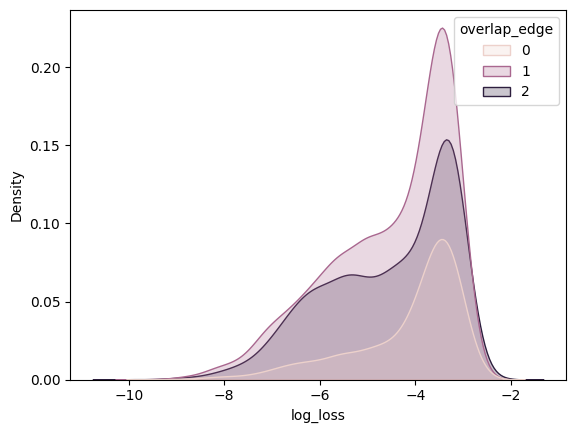

In [42]:
sns.kdeplot(data=df, x="log_loss", hue='overlap_edge', fill=True)

In [55]:
overlap_edge_value =abs(df["x1"][overlap_edge_obj1])+df["r1"][overlap_edge_obj1] + abs(df["y1"][overlap_edge_obj1])+df["r1"][overlap_edge_obj1] + abs(df["x2"][overlap_edge_obj2])+df["r2"][overlap_edge_obj2] + abs(df["y2"][overlap_edge_obj2])+df["r2"][overlap_edge_obj2]



In [58]:
overlap_edge_value.shape

(4232,)

In [62]:
o_x1 = [abs(df["x1"][i])+df["r1"][i] if (abs(df["x1"][i])+df["r1"][i]>0.5) else 0 for i in range(df.shape[0])]
o_y1 = [abs(df["y1"][i])+df["r1"][i] if (abs(df["y1"][i])+df["r1"][i]>0.5) else 0 for i in range(df.shape[0])]
o_x2 = [abs(df["x2"][i])+df["r2"][i] if (abs(df["x2"][i])+df["r2"][i]>0.5) else 0 for i in range(df.shape[0])]
o_y2 = [abs(df["y2"][i])+df["r2"][i] if (abs(df["y2"][i])+df["r2"][i]>0.5) else 0 for i in range(df.shape[0])]

In [67]:
overlap_edge_value = np.array(o_x1) +np.array(o_y1)+np.array(o_x2)+np.array(o_y2)

In [68]:
overlap_edge_value.shape

(5000,)

In [69]:
df["overlap_edge_value"] = overlap_edge_value

<Axes: xlabel='log_loss', ylabel='overlap_edge_value'>

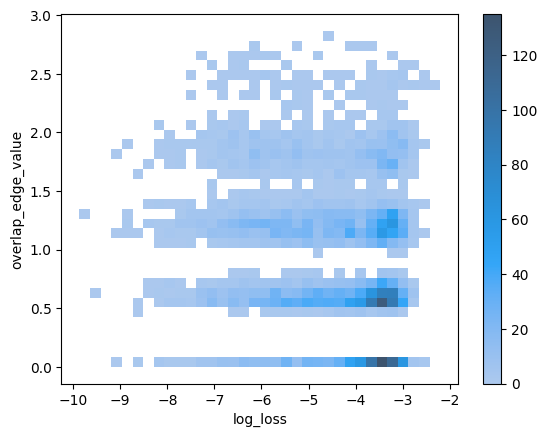

In [72]:
sns.histplot(data=df, x="log_loss", y="overlap_edge_value", cbar=True, )

In [79]:
df["log_loss"]

0      -3.203559
1      -4.158365
2      -3.034045
3      -5.202619
4      -3.505290
          ...   
4995   -3.372746
4996   -5.248517
4997   -3.119325
4998   -4.999130
4999   -3.491189
Name: log_loss, Length: 5000, dtype: float32

In [82]:
from matplotlib.colors import LogNorm

In [89]:
norm = LogNorm(vmin=10**(-8), vmax=10**(-1))

In [98]:
df["log_loss"].describe()

count    5000.000000
mean       -4.482959
std         1.295295
min        -9.867043
25%        -5.402915
50%        -4.067945
75%        -3.418460
max        -2.203895
Name: log_loss, dtype: float64

<Axes: title={'center': '(x,y) histogram of hits weighted with -log_loss'}, xlabel='x1', ylabel='y1'>

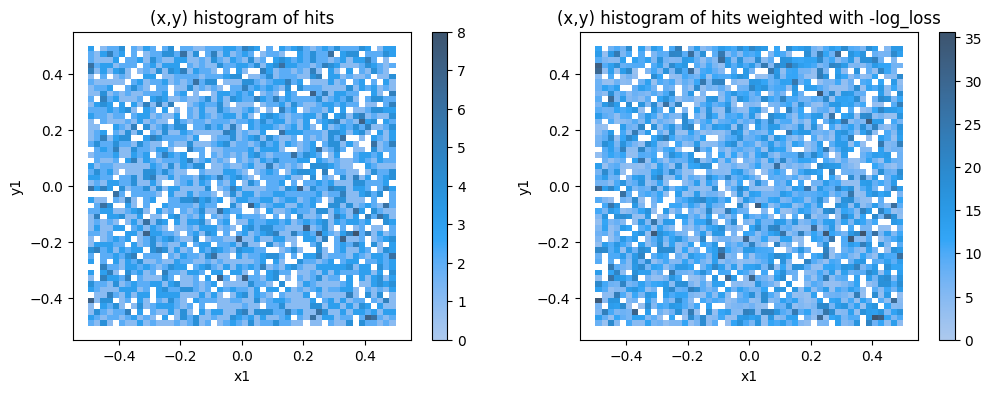

In [107]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(121)
sns.histplot(data=df, x='x1', y='y1', bins=50, cbar=True)
plt.title("(x,y) histogram of hits")
fig.add_subplot(122)
plt.title("(x,y) histogram of hits weighted with -log_loss")
sns.histplot(data=df, x='x1', y='y1', weights=-df["log_loss"], bins=50, cbar=True)

## Compare with smaler ResNet 

In [20]:
with open('./loss_histograms/MyResNet.npy', 'rb') as f:
    n1 = np.load(f)
    bins1 = np.load(f)

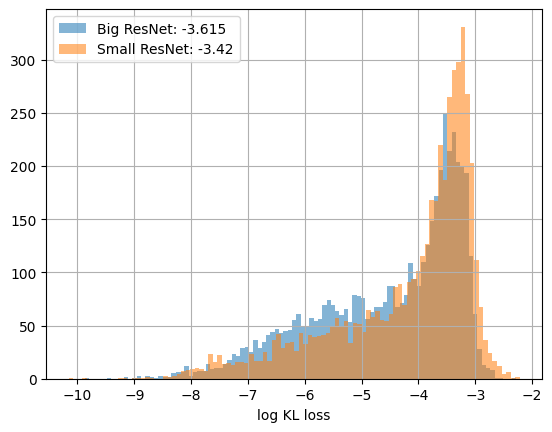

In [29]:
ev.compare_histograms(np.array([n, n1]), np.array([bins, bins1]), ['Big ResNet: -3.615', 'Small ResNet: -3.42'], xlabel='log KL loss')